In [26]:
from Utils import *

In [2]:
trainImages, trainOutput_xi, trainOutput_yi, trainOutput_xw, trainOutput_yw = readImageData('Training')
testImages, testOutput_xi, testOutput_yi, testOutput_xw, testOutput_yw = readImageData('test')

In [3]:
trainImages = preprocess_images(trainImages)
testImages = preprocess_images(testImages)

print(f"Preprocessed train images shape: {trainImages.shape}")
print(f"Preprocessed test images shape: {testImages.shape}")

Preprocessed train images shape: torch.Size([150, 3, 224, 224])
Preprocessed test images shape: torch.Size([40, 3, 224, 224])


In [4]:
trainLabels = torch.tensor(
    list(zip(trainOutput_xi, trainOutput_yi, trainOutput_xw, trainOutput_yw)), dtype=torch.float32
)
testLabels = torch.tensor(
    list(zip(testOutput_xi, testOutput_yi, testOutput_xw, testOutput_yw)), dtype=torch.float32
)
print(f"trainLabels shape: {trainLabels.shape}")
print(f"testLabels shape: {testLabels.shape}")

trainLabels shape: torch.Size([150, 4])
testLabels shape: torch.Size([40, 4])


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 创建 TensorDataset
train_dataset = TensorDataset(trainImages, trainLabels)
test_dataset = TensorDataset(testImages, testLabels)

# 创建 DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 示例：迭代 DataLoader
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break


Batch images shape: torch.Size([16, 3, 224, 224])
Batch labels shape: torch.Size([16, 4])


In [6]:
import torch
import torch.nn as nn

class VGGRegression(nn.Module):
    def __init__(self, config, output_dim=4):
        """
        Initialize the VGG model for regression tasks.
        
        Args:
            config (list): Configuration for convolutional and pooling layers.
            output_dim (int): Number of output dimensions. Default is 4 (x, y, x_width, y_width).
        """
        super(VGGRegression, self).__init__()
        self.features = self._make_layers(config)
        self.regressor = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Assuming input size is 224x224
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_dim),  # Final output: 4 values for regression
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten for the fully connected layer
        x = self.regressor(x)
        return x

    def _make_layers(self, config):
        layers = []
        in_channels = 3  # RGB input
        for layer in config:
            if layer == 'M':  # Max pooling
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:  # Convolutional layer
                layers += [
                    nn.Conv2d(in_channels, layer, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                ]
                in_channels = layer
        return nn.Sequential(*layers)

# Example: VGG16 configuration
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

# Instantiate the model for regression (output 4 values)
vgg_regression = VGGRegression(vgg16_config, output_dim=4)

print(vgg_regression)


VGGRegression(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

Epoch [10/120], Loss: 6080.4199
Epoch [20/120], Loss: 6408.3467
Epoch [30/120], Loss: 6110.1944
Epoch [40/120], Loss: 5897.4756
Epoch [50/120], Loss: 5921.0057
Epoch [60/120], Loss: 8115.7330
Epoch [70/120], Loss: 6025.3513
Epoch [80/120], Loss: 5235.1402
Epoch [90/120], Loss: 5449.8906
Epoch [100/120], Loss: 5518.5368
Epoch [110/120], Loss: 4940.4995
Epoch [120/120], Loss: 5954.0746


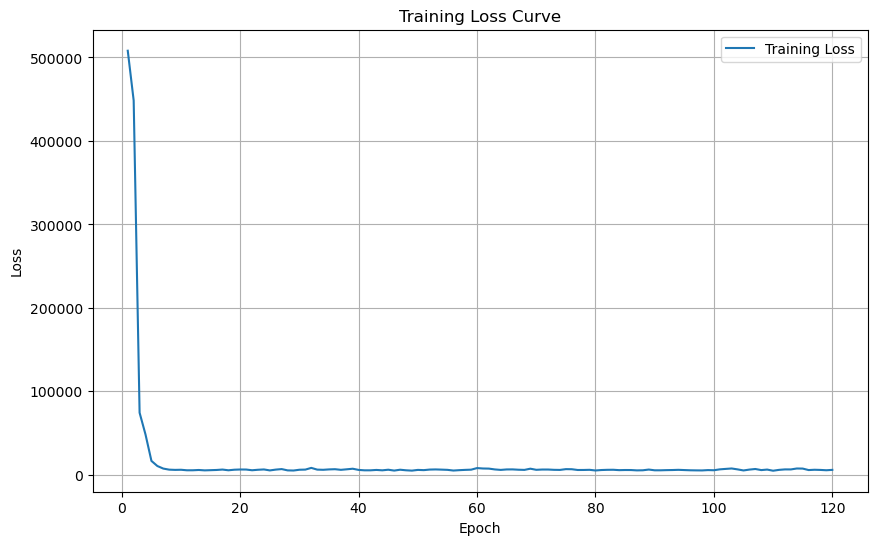

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import joblib
import os

# Save the Model
save_dir = 'Models'

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
vgg_regression = vgg_regression.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(vgg_regression.parameters(), lr=1e-4)
criterion = nn.MSELoss()  # Mean Squared Error for regression

# Training loop
num_epochs = 120
train_losses = []  # List to store loss values

for epoch in range(num_epochs):
    vgg_regression.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear gradients
        outputs = vgg_regression(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()
    
    # Calculate average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)  # Record loss
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Save the model every epoch
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'vgg_regression_Epoch_{epoch+1}_{num_epochs}_model.pkl')
    joblib.dump(vgg_regression, save_path)

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
import os

# Folder where the models are stored
model_folder = "Models"

# List all the model files in the folder
model_files = [f for f in os.listdir(model_folder) if f.endswith(".pkl")]

In [32]:
# Initialize variables to track the best model
best_model_file = None
best_model_loss = float('inf')  # Start with a very large loss
best_model_predictions = None
best_model_labels = None

# Iterate over each model file
for model_file in model_files:
    model_path = os.path.join(model_folder, model_file)
    
    # Load the model
    model = joblib.load(model_path)
    model = model.to(device)  # Move model to device
    model.eval()  # Set model to evaluation mode
    
    # Initialize metrics for this model
    total_loss = 0.0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            predictions = model(images)
            
            # Compute loss
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            
            # Store predictions and labels for further analysis
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Aggregate results
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    
    # Compute final metrics for this model
    average_loss = total_loss / len(test_loader)
    # print(f"Model: {model_file}, Average Loss: {average_loss:.4f}")
    
    # Update the best model if this one is better
    if average_loss < best_model_loss:
        best_model_loss = average_loss
        best_model_file = model_file
        best_model_predictions = all_predictions
        best_model_labels = all_labels

# Print the best model information
print(f"Best Model: {best_model_file}, Lowest Average Loss: {best_model_loss:.4f}")

# Optionally: Save the best model predictions and labels for analysis
np.save('best_model_predictions.npy', best_model_predictions)
np.save('best_model_labels.npy', best_model_labels)

Best Model: vgg_regression_Epoch_27_120_model.pkl, Lowest Average Loss: 2134.5365
